# Functions

In [ ]:
!pip install opencv-python==3.4.2.17
!pip install opencv-contrib-python==3.4.2.17

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from scipy.ndimage.filters import convolve as convolveim
import scipy.ndimage.filters as filters
import scipy.ndimage as ndimage
import math

#%matplotlib inline

In [ ]:
# Spherical Projection
def spherical_projection(img, r) :
   rows = img.shape[0]
   cols = img.shape[1]
   blank = np.zeros_like(img)
   center_x = int(rows / 2)
   center_y = int(cols / 2)

   # r = int(((rows**2+cols**2)**0.5)/2)+20
   pz = r
   
   for xt in range(rows):
       ox = xt
       x = xt - center_x
       for yt in range(cols):
           oy = yt
           y = yt - center_y
           z = (r*r - x*x - y*y)**0.5
           # 假设光源点为（0， 0， 2r）
           k = (pz - 2*r) / (z - 2*r)
           px = int(k*x)
           py = int(k*y)
           px = px + center_x
           py = py + center_y
           blank[px, py] = img[ox, oy]
  
   return blank

In [ ]:
def edge_delete(img):
    rows, cols = img.shape

    left = 0
    right = 0
    top = 0
    bott = 0
    for col in range(0, cols):
        if img[:, col].any():
            left = col
            break
    for col in range(cols - 1, 0, -1):
        if img[:, col].any():
            right = col
            break

    for row in range(0, rows):
        if img[row, :].any():
            top = row
            break
    for row in range(rows - 1, 0, -1):
        if img[row, :].any():
            bott = row
            break

    blank = np.zeros((right - left + 1, bott - top + 1))
    blank = img[top:bott + 1, left:right + 1].astype(np.uint8)

    plt.figure(figsize=(20,20))
    plt.imshow(blank, cmap='gray')
    return blank

In [ ]:
def stitch(img1, img2):

    # use SIFT to detect features
    sift = cv2.xfeatures2d.SIFT_create()

    kp1 = sift.detect(img1, None)
    kp2 = sift.detect(img2, None)

    # Visualize the keypoints
    img1_kps = cv2.drawKeypoints(img1,kp1,None,flags = cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
    img2_kps = cv2.drawKeypoints(img2,kp2,None,flags = cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)

    # Use sift.compute to generate sift descriptors/features
    (kp1, features1) = sift.compute(img1,kp1)
    (kp2, features2) = sift.compute(img2,kp2)


    kp1 = np.float32([kp.pt for kp in kp1])
    kp2 = np.float32([kp.pt for kp in kp2])

    matcher = cv2.DescriptorMatcher_create("BruteForce")

    # Use knnMatch function in matcher to find corresonding features
    # For robustness of the matching results, we'd like to find 2 best matches (i.e. k=2 for knnMatch) 
    # and return their matching distances 
    rawMatches = matcher.knnMatch(features1, features2, k=2)
    matches = []

    # validate if the matching is reliable by checking if the best maching distance is less than 
    # the second matching by a threshold, for example, 20% of the 2nd best maching distance
    for m in rawMatches:
        # Ensure the distance is within a certain ratio of each other ( i.e. Lowe's ratio test)
        # Test the distance between points. use m[0].distance and m[1].distance
        if len(m) == 2 and (m[0].distance < 0.8 * m[1].distance) : 
            matches.append((m[0].trainIdx, m[0].queryIdx))

    ptsA = np.float32([kp1[i] for (_,i) in matches])
    ptsB = np.float32([kp2[i] for (i,_) in matches])

    # Find homography with RANSAC
    (H, status) = cv2.findHomography(ptsB ,ptsA, cv2.RANSAC)

    # fill in the arguments to warp the second image to fit the first image.
    # First transform the right image, then fill in the left part with the orignal left image
    (rows, cols) = img1.shape[:2]
    (rows2, cols2) = img2.shape[:2]
    result = cv2.warpPerspective(img2, H, dsize=(int(cols + cols), int(rows + rows)))

    preliminary = result.copy()
    #preliminary[0:rows, 0:cols] = img1
    plt.figure(figsize=(15,15))
    plt.imshow(preliminary, cmap='gray')
    plt.title('Preliminary result of Cylindrical Projection')

    # Blend images and eluminate black borders
    for col in range(0,cols):
        if img1[:, col].any() and result[:, col].any():#开始重叠的最左端
            left = col
            break
    for col in range(cols-1, 0, -1):
        if img1[:, col].any() and result[:, col].any():#重叠的最右一列
            right = col
            break

    res = np.zeros([rows, cols], np.uint8)
    for row in range(0, rows):
        for col in range(0, cols):
            if not img1[row, col].any():#如果没有原图，用旋转的填充
                res[row, col] = result[row, col]
            elif not result[row, col].any():
                res[row, col] = img1[row, col]
            else:
                srcImgLen = float(abs(col - left))
                testImgLen = float(abs(col - right))
                alpha = srcImgLen / (srcImgLen + testImgLen)
                res[row, col] = np.clip(img1[row, col] * (1-alpha) + result[row, col] * alpha, 0, 255)

    result[0:img1.shape[0], 0:img1.shape[1]]=res
    plt.figure(figsize=(15,15))
    plt.imshow(result, 'gray')
    plt.title('Final Result of Cylindrical Projection')
    plt.show()

    return result

## Another Test

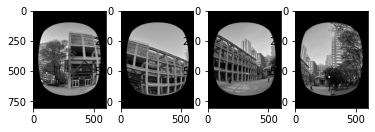

In [ ]:
# 读取图片
test1 = cv2.imread('/content/drive/MyDrive/Colab Notebooks/IVP/Test6/a.jpeg',0)
test2 = cv2.imread('/content/drive/MyDrive/Colab Notebooks/IVP/Test6/b.jpg',0)
test3 = cv2.imread('/content/drive/MyDrive/Colab Notebooks/IVP/Test6/c.jpg',0)
test4 = cv2.imread('/content/drive/MyDrive/Colab Notebooks/IVP/Test6/d.jpg',0)

# Resized image to reduce computation of finding features and stitching
k = 5
height = int((test1.shape[0])/k)
width = int((test1.shape[1])/k)
# resize the image by resize() function of openCV library
test1 = cv2.resize(test1, (width, height), interpolation=cv2.INTER_AREA)
test2 = cv2.resize(test2, (width, height), interpolation=cv2.INTER_AREA)
test3 = cv2.resize(test3, (width, height), interpolation=cv2.INTER_AREA)
test4 = cv2.resize(test4, (width, height), interpolation=cv2.INTER_AREA)

test1 = spherical_projection(test1, 540)
test2 = spherical_projection(test2, 540)
test3 = spherical_projection(test3, 540)
test4 = spherical_projection(test4, 540)

plt.figure()
plt.subplot(141)
plt.imshow(test1, cmap='gray')
plt.subplot(142)
plt.imshow(test2, cmap='gray')
plt.subplot(143)
plt.imshow(test3, cmap='gray')
plt.subplot(144)
plt.imshow(test4, cmap='gray')

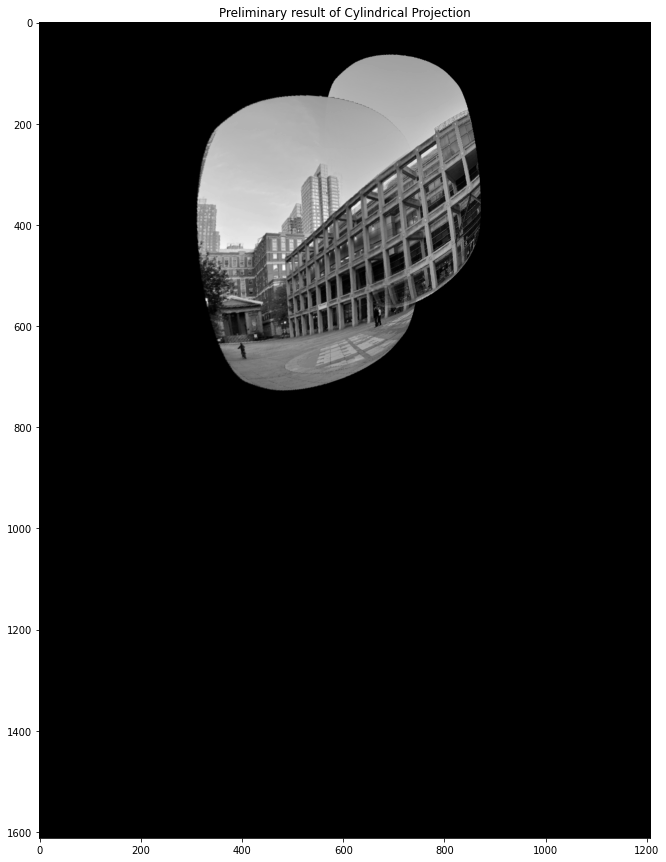

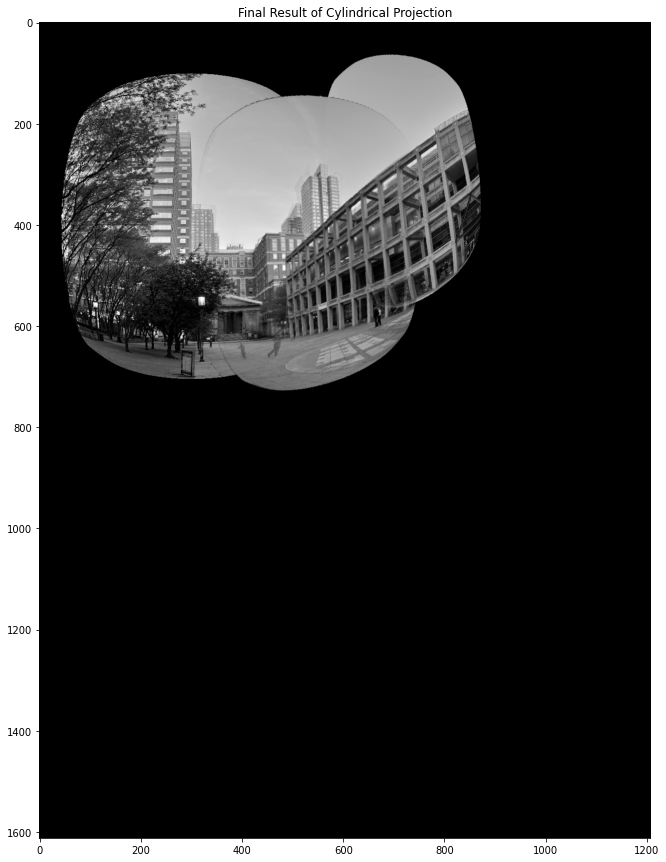

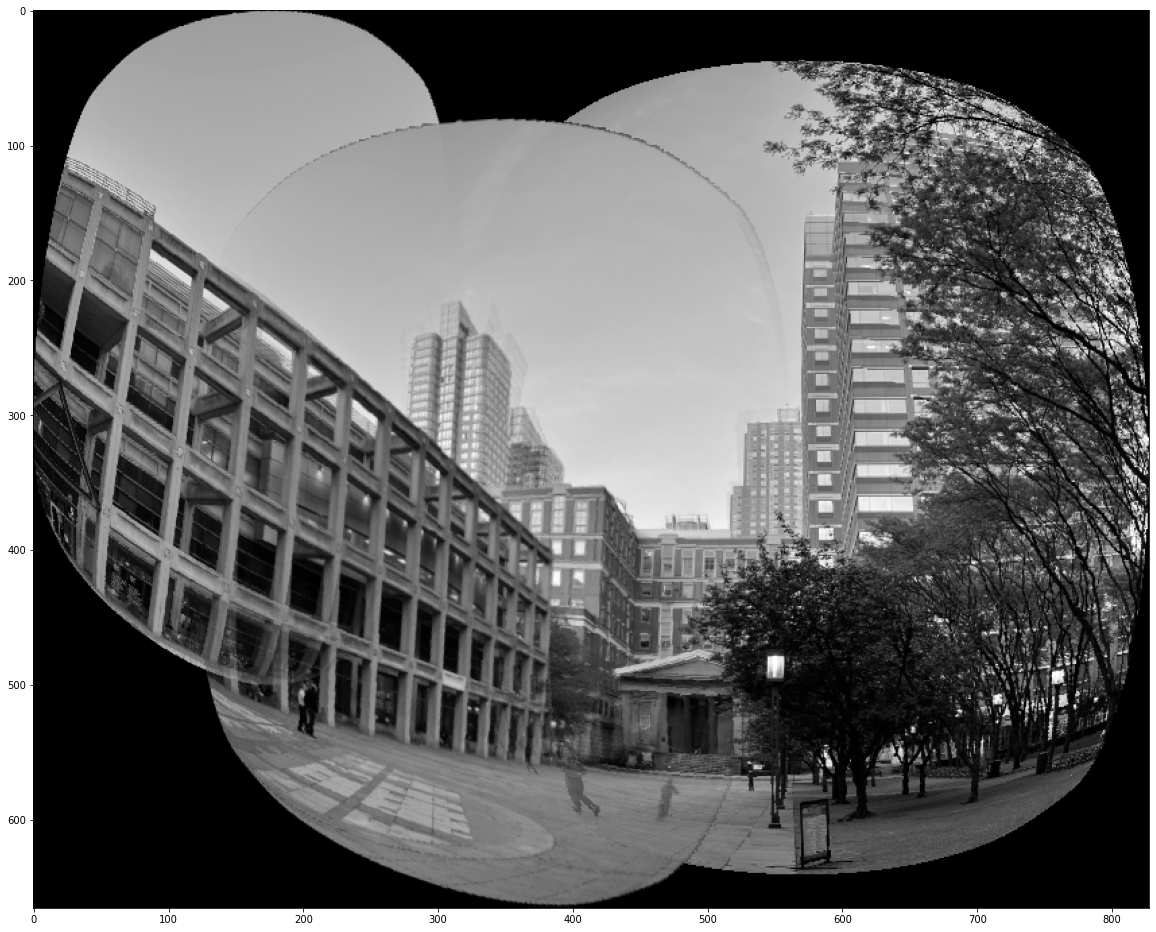

In [ ]:
test4f = cv2.flip(test4, 1)
test23f = cv2.flip(test23, 1)
test234f = stitch(test4f, test23f)
test234 = cv2.flip(test234f, 1)
test234 = edge_delete(test234)